## ## Graph Convolution Networks 

Generating embedding for a graph dataset using a Graph Convolution Neural Network (GCN) on Zachary's Karate Club Network

Data file from: http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm
> Zachary W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33, 452-473.

This is a classic dataset to look at relationships between users and their effect on the decision. 

How this useful? 
- Calculate embedding to compress the graph dataset into 2 dimensions 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%config InlineBackend.figure_format = 'retina'

import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'lines.linewidth' : 3,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

In [3]:
G = nx.karate_club_graph()
print("Node Degree")
for v in G:
    print(f"{v:4} {G.degree(v):6}")

Node Degree
   0     16
   1      9
   2     10
   3      6
   4      3
   5      4
   6      4
   7      4
   8      5
   9      2
  10      3
  11      1
  12      2
  13      5
  14      2
  15      2
  16      2
  17      2
  18      2
  19      3
  20      2
  21      2
  22      2
  23      5
  24      3
  25      3
  26      2
  27      4
  28      3
  29      4
  30      4
  31      6
  32     12
  33     17


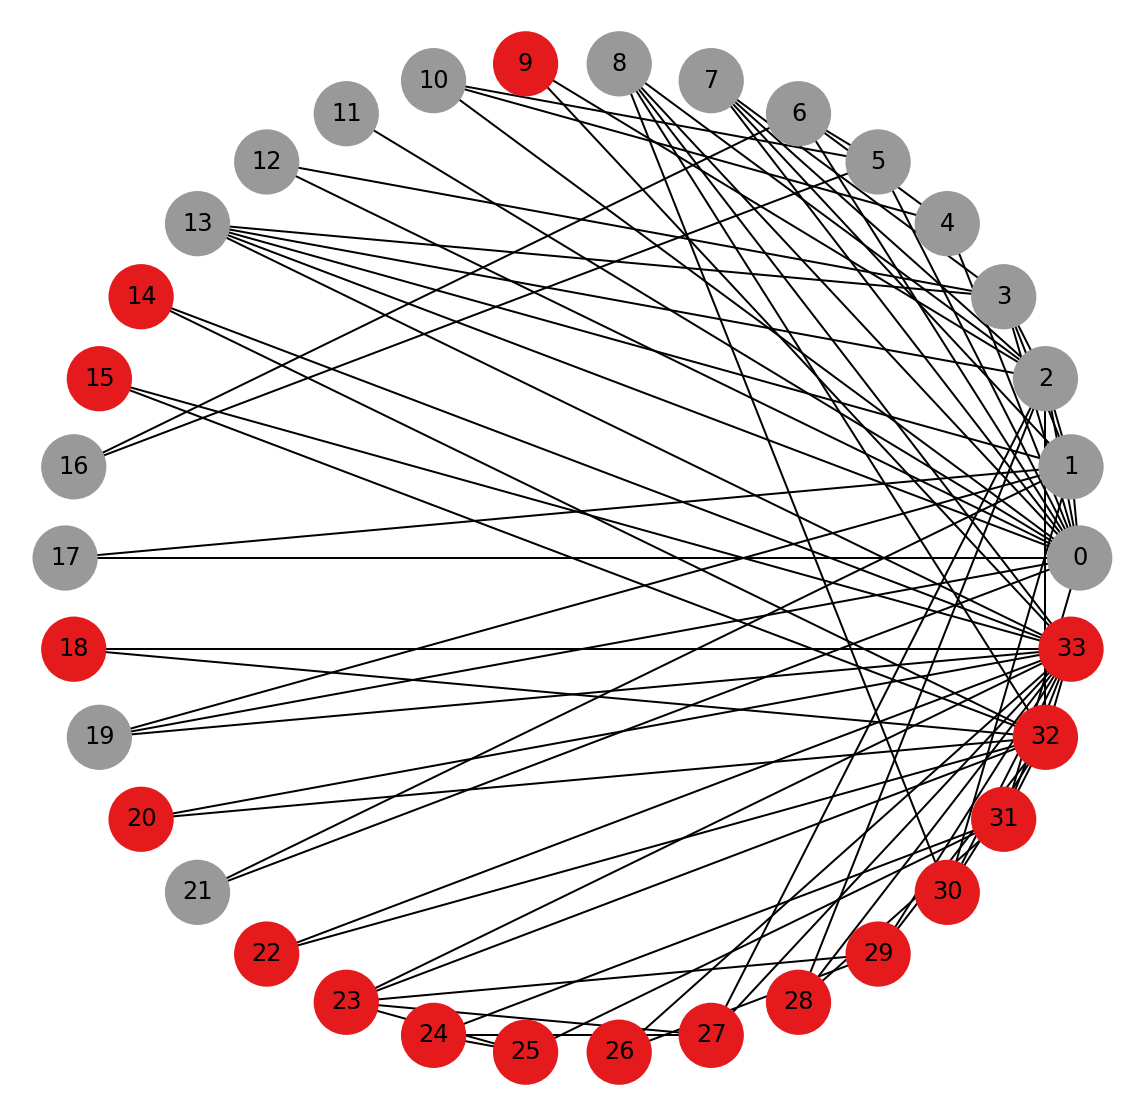

In [4]:
club_officer = []
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(G.nodes)):
    if G.nodes[i]['club'] == 'Mr. Hi':
        club_officer.append(1)
    else:
        club_officer.append(0)
nx.draw_circular(G, node_color=club_officer, node_size=10**3, cmap=cm.Set1, with_labels=True, ax=ax)
plt.show()

Each node in the graph is a person. Every person has an associated number (index) and the club they would eventually join. In this form of visualization - node 0 and node 33 are Mr. Hi and Officer respectively. Besides that, each node has an associated edges with other nodes in the network based on connections (how exactly are those determined is not clear at first). Now having that connection we can construct an adjacency matrix. The environment of each node can be used to predict the final club the user would end up in. 

We can re-express this problem as given the nodes and the connections which club would each node join. We can see if the GCN network can predict the targets properly or rather if the targets can be used to find low dimensional embeddings for the graph objects such that each node is expressed in 2D. 

In [5]:
Karate_adjacency = torch.Tensor(nx.to_numpy_matrix(G))

In [31]:
class GCNConv(nn.Module):
    def __init__(self, A, input_dims, output_dims):
        super(GCNConv, self).__init__()
        '''
        As per Tipf explanation: 
        https://tkipf.github.io/graph-convolutional-networks/
        https://arxiv.org/abs/1609.02907
        
        '''
        self.A_hat = A + torch.eye(A.size(0))
        
        self.D     = torch.diag(torch.sum(A,1)) #Diagonal node-degree matrix 
        self.D     = self.D.inverse().sqrt()
        
        self.A_hat = torch.mm(torch.mm(self.D, self.A_hat), self.D)
        
        self.W     = nn.Parameter(torch.rand(input_dims, output_dims, requires_grad=True))
    
    def forward(self, X):
        
        out = torch.relu(torch.mm( torch.mm(self.A_hat, X), self.W ))
        return out

In [32]:
class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A, nfeat, nhid)
        self.conv2 = GCNConv(A,nhid, nout)
        
    def forward(self,X):
        H  = self.conv1(X)
        H2 = self.conv2(H)
        return H2

In [33]:
target = torch.tensor(club_officer)

## ## Input vector for representing each node 

In [34]:
X=torch.eye(Karate_adjacency.size(0))

In [35]:
simple_GCN = Net(Karate_adjacency, X.size(0), 15, 2)

In [36]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD( simple_GCN.parameters(), lr=0.1, momentum=0.9 )

In [37]:
loss=criterion( simple_GCN(X), target )

In [38]:
loss

tensor(1.2534, grad_fn=<NllLossBackward>)

In [39]:
output_random = simple_GCN(X).detach().numpy()
comp1 = output_random[:,0]
comp2 = output_random[:,1]

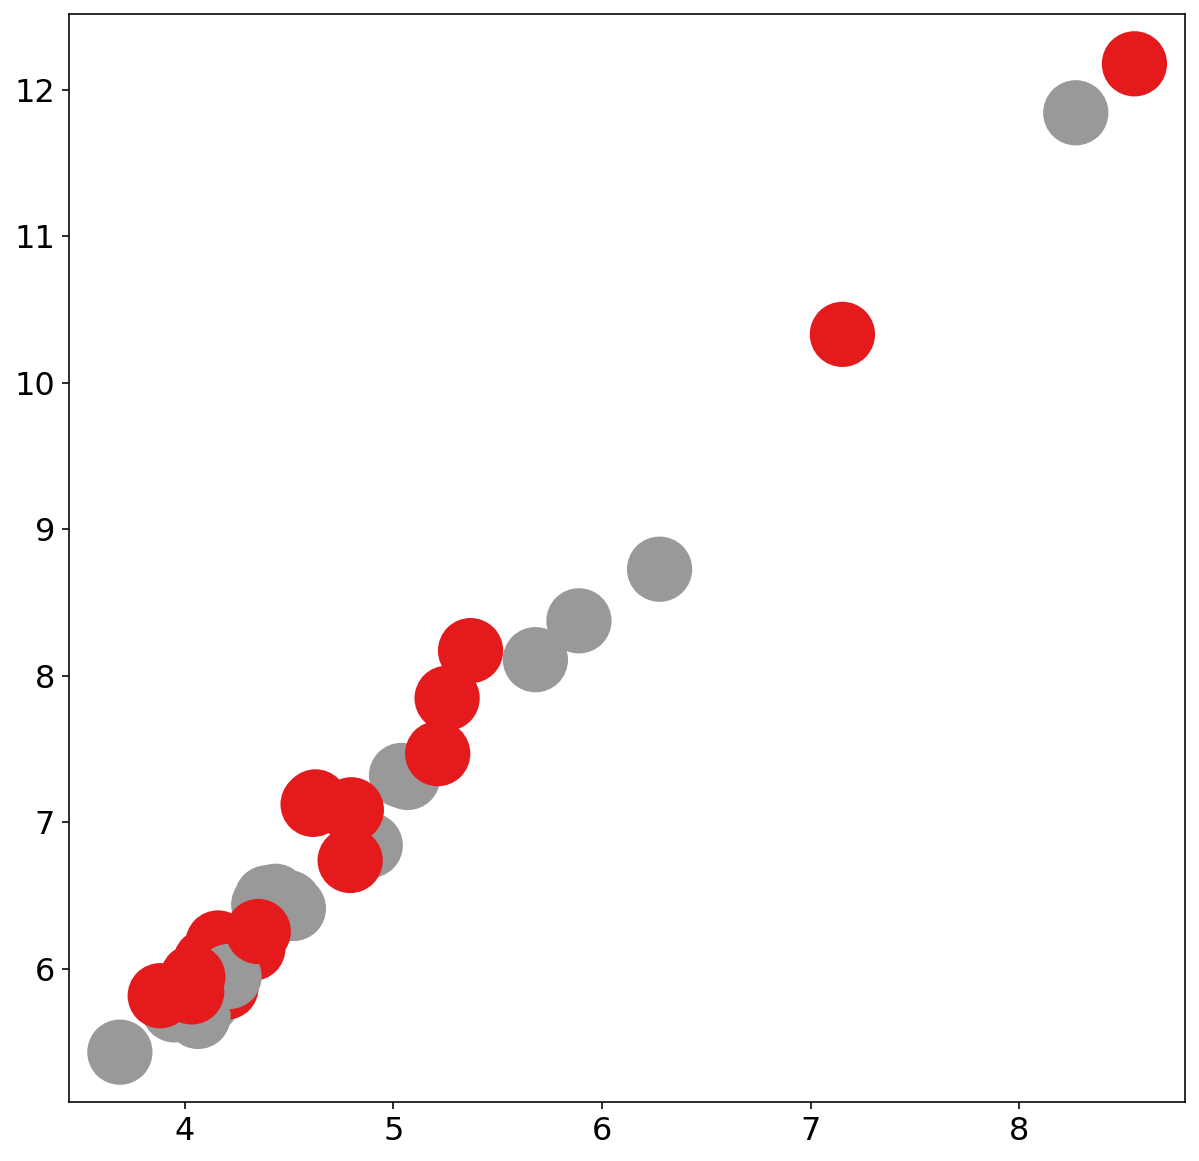

In [40]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(comp1, comp2, c=club_officer, s=10**3, cmap=cm.Set1);

The embeddings from the randomized initialization do not correspond to any clustering -- the red and grey points belong to 2 classes used in the dataset. Every node is condensed in two 2 dimensions here 

## ## Training the network to find low dimensional embeddings 

In [41]:
for i in range(500):
    output = simple_GCN(X)
    optimizer.zero_grad()
    loss=criterion(output, target)
    loss.backward()
    optimizer.step()
    l=(simple_GCN(X)); 
    if i % 100==0:
        print("Cross Entropy Loss: =", loss.item())

Cross Entropy Loss: = 1.253422737121582
Cross Entropy Loss: = 0.04196850582957268
Cross Entropy Loss: = 0.03152116760611534
Cross Entropy Loss: = 0.024973291903734207
Cross Entropy Loss: = 0.01996554061770439


In [42]:
output_ = simple_GCN(X).detach().numpy()
out_comp1 = output_[:,0]
out_comp2 = output_[:,1]

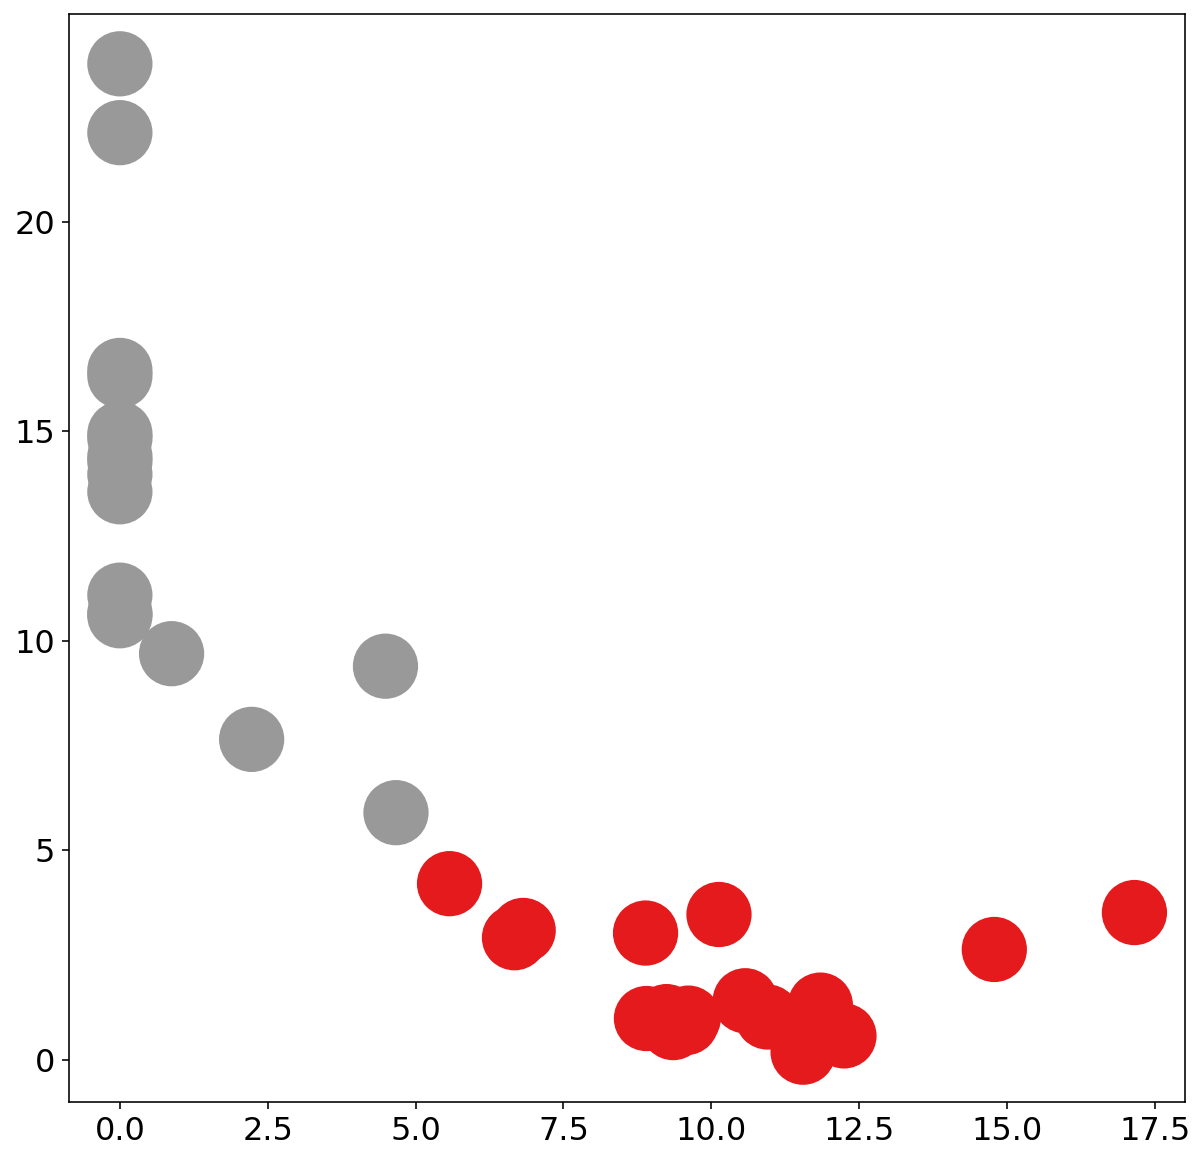

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(out_comp1, out_comp2, c=club_officer, s=10**3, cmap=cm.Set1);

The low dimensional embeddings learned from the target properties of the node are able to cluster into. Now this is useful as we can condense the high-dimensional graph network into 2D and label them as per the target and see the clustering. 

## ## Using PyTorch Geometric

In [46]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [47]:
class GraphConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, bias=True, **kwargs):
        super(GraphConvolution, self).__init__(aggr='add', **kwargs)
        self.lin = torch.nn.Linear(in_channels, out_channels,bias=bias)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

In [48]:
class Net(torch.nn.Module):
    def __init__(self,nfeat, nhid, nclass, dropout):
        super(Net, self).__init__()
        self.conv1 = GraphConvolution(nfeat, nhid)
        self.conv2 = GraphConvolution(nhid, nclass)
        self.dropout=dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)